In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201

###
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Define the distiller model by gpt
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
path = '/content/drive/My Drive/Aravind eye dataset/aptos2019-blindness-detection/train_split'

In [5]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models

# Load DenseNet-121 model without the top layers (pre-trained on ImageNet)
DenseNet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the teacher model
teacher = models.Sequential([
    DenseNet201_model,                  # MobileNetV2 base model
    layers.GlobalAveragePooling2D(),    # Reduces dimensionality (spatial pooling)
    layers.Dropout(0.2),                # Dropout to prevent overfitting
    layers.Dense(1024, activation='relu'), # Fully connected layer with ReLU activation
    layers.Dropout(0.2),                # Dropout
    layers.Dense(512, activation='relu'),  # Another dense layer with ReLU
    layers.Dense(5, activation='softmax')  # Final output layer (assuming 5 classes)
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

# Clone the student model for scratch training comparison
student_scratch = models.clone_model(student)

# Image data generators
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 600)            │        39,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,293 (1.76 MB)

 Trainable params: 460,293 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
import tensorflow as tf
from tensorflow import keras # Import the keras module

#Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-11 12:26:38.799917:

92/92 ━━━━━━━━━━━━━━━━━━━━ 567s 6s/step - sparse_categorical_accuracy: 0.4854 - distillation_loss: 0.0144 - loss: 0.2000 - student_loss: 1.3237 - val_sparse_categorical_accuracy: 0.4938 - val_loss: 0.2000 - val_student_loss: 1.1849
Epoch 2/25


2024-09-11 12:35:58.684275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 12:36:08.393367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - sparse_categorical_accuracy: 0.6160 - distillation_loss: 0.0209 - loss: 0.2000 - student_loss: 1.0716 - val_sparse_categorical_accuracy: 0.6881 - val_loss: 0.2000 - val_student_loss: 0.8190
Epoch 3/25


2024-09-11 12:44:16.752412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 12:44:26.108439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - sparse_categorical_accuracy: 0.6977 - distillation_loss: 0.0222 - loss: 0.2000 - student_loss: 0.9869 - val_sparse_categorical_accuracy: 0.6922 - val_loss: 0.2000 - val_student_loss: 1.1530
Epoch 4/25


2024-09-11 12:52:45.348442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 12:52:56.420156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 525s 5s/step - sparse_categorical_accuracy: 0.7245 - distillation_loss: 0.0223 - loss: 0.2000 - student_loss: 0.9679 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 0.7575
Epoch 5/25


2024-09-11 13:01:30.069464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 13:01:41.805694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 473s 5s/step - sparse_categorical_accuracy: 0.7187 - distillation_loss: 0.0224 - loss: 0.2000 - student_loss: 0.9600 - val_sparse_categorical_accuracy: 0.6949 - val_loss: 0.2000 - val_student_loss: 0.8004
Epoch 6/25


2024-09-11 13:09:22.374298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-11 13:09:34.725348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-11 13:09:37.730055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - sparse_categorical_accuracy: 0.7153 - distillation_loss: 0.0225 - loss: 0.2000 - student_loss: 0.9581 - val_sparse_categorical_accuracy: 0.7086 - val_loss: 0.2000 - val_student_loss: 0.8846
Epoch 7/25


2024-09-11 13:17:52.643498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 13:18:05.319071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 473s 5s/step - sparse_categorical_accuracy: 0.7114 - distillation_loss: 0.0226 - loss: 0.2000 - student_loss: 0.9524 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 1.1278
Epoch 8/25


2024-09-11 13:25:46.559909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 13:25:57.792201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - sparse_categorical_accuracy: 0.7103 - distillation_loss: 0.0222 - loss: 0.2000 - student_loss: 0.9590 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.8533
Epoch 9/25


2024-09-11 13:34:31.301898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 13:34:42.510313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 669s 7s/step - sparse_categorical_accuracy: 0.7209 - distillation_loss: 0.0227 - loss: 0.2000 - student_loss: 0.9415 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.8028
Epoch 10/25


2024-09-11 13:45:42.128160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 13:45:54.711896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 952s 10s/step - sparse_categorical_accuracy: 0.7215 - distillation_loss: 0.0228 - loss: 0.2000 - student_loss: 0.9342 - val_sparse_categorical_accuracy: 0.7004 - val_loss: 0.2000 - val_student_loss: 1.1209
Epoch 11/25


2024-09-11 14:01:32.455071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-11 14:01:45.526766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-11 14:01:56.339081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-11 14:02:01.781015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 1029s 11s/step - sparse_categorical_accuracy: 0.7069 - distillation_loss: 0.0231 - loss: 0.2000 - student_loss: 0.9449 - val_sparse_categorical_accuracy: 0.7141 - val_loss: 0.2000 - val_student_loss: 0.8460
Epoch 12/25


2024-09-11 14:18:44.152933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-11 14:19:02.328619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-11 14:19:07.674313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 534s 5s/step - sparse_categorical_accuracy: 0.7219 - distillation_loss: 0.0230 - loss: 0.2000 - student_loss: 0.9351 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.9578
Epoch 13/25


2024-09-11 14:27:36.777710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-11 14:27:45.791107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 462s 5s/step - sparse_categorical_accuracy: 0.7240 - distillation_loss: 0.0229 - loss: 0.2000 - student_loss: 0.9332 - val_sparse_categorical_accuracy: 0.6977 - val_loss: 0.2000 - val_student_loss: 0.8975
Epoch 14/25


2024-09-11 14:35:18.668733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 14:35:29.463155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - sparse_categorical_accuracy: 0.7287 - distillation_loss: 0.0234 - loss: 0.2000 - student_loss: 0.9277 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 0.9385
Epoch 15/25


2024-09-11 14:42:54.270345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 14:43:05.272103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - sparse_categorical_accuracy: 0.7328 - distillation_loss: 0.0231 - loss: 0.2000 - student_loss: 0.9268 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 1.0369
Epoch 16/25


2024-09-11 14:50:32.613118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 14:50:44.700452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - sparse_categorical_accuracy: 0.7133 - distillation_loss: 0.0232 - loss: 0.2000 - student_loss: 0.9232 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.9546
Epoch 17/25


2024-09-11 14:58:10.178000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 14:58:20.847211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 462s 5s/step - sparse_categorical_accuracy: 0.7266 - distillation_loss: 0.0231 - loss: 0.2000 - student_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7209 - val_loss: 0.2000 - val_student_loss: 0.8993
Epoch 18/25


2024-09-11 15:05:53.119660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:06:05.103502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - sparse_categorical_accuracy: 0.7241 - distillation_loss: 0.0234 - loss: 0.2000 - student_loss: 0.9197 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.8914
Epoch 19/25


2024-09-11 15:13:28.383723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:13:39.841370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - sparse_categorical_accuracy: 0.7312 - distillation_loss: 0.0232 - loss: 0.2000 - student_loss: 0.9187 - val_sparse_categorical_accuracy: 0.7073 - val_loss: 0.2000 - val_student_loss: 0.7136
Epoch 20/25


2024-09-11 15:21:02.184761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:21:14.612841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - sparse_categorical_accuracy: 0.7221 - distillation_loss: 0.0236 - loss: 0.2000 - student_loss: 0.9175 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 1.1387
Epoch 21/25


2024-09-11 15:28:37.540172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:28:48.359966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - sparse_categorical_accuracy: 0.7157 - distillation_loss: 0.0235 - loss: 0.2000 - student_loss: 0.9115 - val_sparse_categorical_accuracy: 0.7045 - val_loss: 0.2000 - val_student_loss: 1.0301
Epoch 22/25


2024-09-11 15:36:10.992339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:36:22.500120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - sparse_categorical_accuracy: 0.7188 - distillation_loss: 0.0232 - loss: 0.2000 - student_loss: 0.9199 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 1.1561
Epoch 23/25


2024-09-11 15:43:46.246999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:43:57.312460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - sparse_categorical_accuracy: 0.7218 - distillation_loss: 0.0237 - loss: 0.2000 - student_loss: 0.9061 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 0.9679
Epoch 24/25


2024-09-11 15:51:33.861070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:51:43.766254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 483s 5s/step - sparse_categorical_accuracy: 0.7154 - distillation_loss: 0.0233 - loss: 0.2000 - student_loss: 0.9106 - val_sparse_categorical_accuracy: 0.7223 - val_loss: 0.2000 - val_student_loss: 0.9675
Epoch 25/25


2024-09-11 15:59:37.381093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-11 15:59:48.732617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - sparse_categorical_accuracy: 0.7267 - distillation_loss: 0.0237 - loss: 0.2000 - student_loss: 0.9058 - val_sparse_categorical_accuracy: 0.7223 - val_loss: 0.2000 - val_student_loss: 1.1518


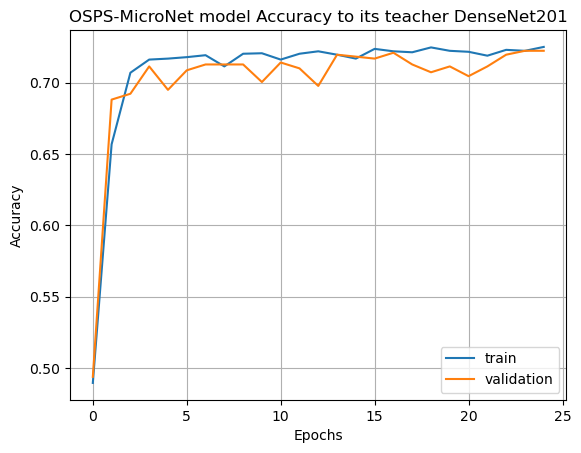

In [7]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher DenseNet201')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [8]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DenseNet201 model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DenseNet201 model is 72.22982048988342
